# 0.0 Imports

In [9]:
import pandas as pd
import numpy as np
import inflection
import math
import random
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import datetime
import warnings
import pickle
import requests
from matplotlib import gridspec
from IPython.core.display import HTML
warnings.filterwarnings('ignore')
from boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 9]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    sns.set()
    
jupyter_settings()

def cramer_v(x,y):
    
    cm = pd.crosstab(x ,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)/y))

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat)/y)


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose = False):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed (range(1,6)):
        #print('\nKFold Number: {}'.format(k))
        # star and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        #training
        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date','sales'], axis=1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat = m.predict(xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        #store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                          'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' = / - ' + np.round(np.std(mae_list),2).astype(str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' = / - ' + np.round(np.std(mape_list),2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' = / - ' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

In [5]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Data description

In [4]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 
            'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 
            'Promo2SinceYear', 'PromoInterval']

In [6]:
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

In [7]:
df1.columns = cols_new

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimension

In [9]:
df1.shape

(1017209, 18)

## 1.3 Data Types

In [10]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
# changing date type

df1['date'] =  pd.to_datetime(df1['date'])

## 1.4 Check Na

In [12]:
df1.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [13]:
# competition_distance  -- distance in meters to the nearest competitor store           
# competition_open_since_month    -- gives the approximate year and month of the time the nearest competitor was opened
# competition_open_since_year     
# promo2_since_week --  describes the year and calendar week when the store started participating in Promo
# promo2_since_year               
# promo_interval   -- describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. 
#                      E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store               

In [14]:
# competition_distance

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

In [15]:
# competition_open_since_month 

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )

In [16]:
# competition_open_since_year 

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )

In [17]:
# promo2_since_week 

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1 )

In [18]:
# promo2_since_year  

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1 )

In [19]:
# promo_interval

month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

In [20]:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [21]:
df1.isnull().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [22]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

### 1.7.1 Numerical Attributes

In [23]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Central tendecy - mean, median
# Dispersion - std, min, max, skew, kurtosis
skew = df1.skew()
kurt = df1.kurtosis()

In [24]:
metrics = pd.DataFrame(df1.describe().drop(['count','25%','75%']).T)
metrics = pd.concat([metrics, skew, kurt], axis=1)
metrics.columns = ['Mean','Std','Min','Median','Max','Skew','Kurtosis']
metrics

,Mean,Std,Min,Median,Max,Skew,Kurtosis
store,558.430,321.909,1.000,558.000,1115.000,-0.001,-1.201
day_of_week,3.998,1.997,1.000,4.000,7.000,0.002,-1.247
sales,5773.819,3849.926,0.000,5744.000,41551.000,0.641,1.778
customers,633.146,464.412,0.000,609.000,7388.000,1.599,7.092
open,0.830,0.376,0.000,1.000,1.000,-1.758,1.091
promo,0.382,0.486,0.000,0.000,1.000,0.488,-1.762
school_holiday,0.179,0.383,0.000,0.000,1.000,1.678,0.815
competition_distance,5935.443,12547.653,20.000,2330.000,200000.000,10.242,147.790
competition_open_since_month,6.787,3.311,1.000,7.000,12.000,-0.042,-1.233
competition_open_since_year,2010.325,5.516,1900.000,2012.000,2015.000,-7.236,124.071


### 1.7.2 Categorical Attributes

In [25]:
sns.set_style('darkgrid')

In [26]:
cat_atributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]','int32','float32'])
cat_atributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

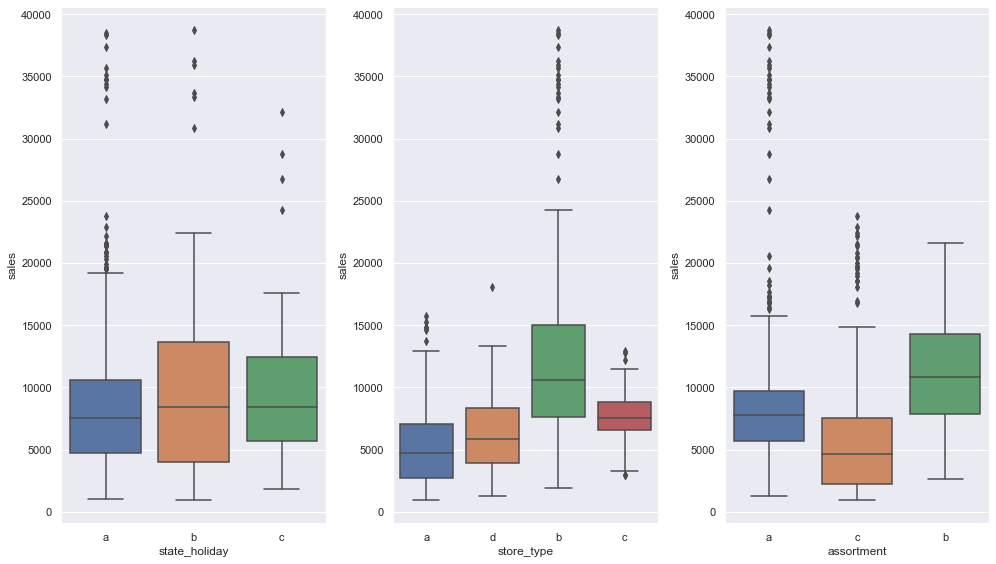

In [27]:
plt.figure(figsize=(14,8))
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

plt.tight_layout()

# 2.0 Feature Engineering

In [28]:
df2 = df1.copy()

## 2.1 Mind Map Hypotheses

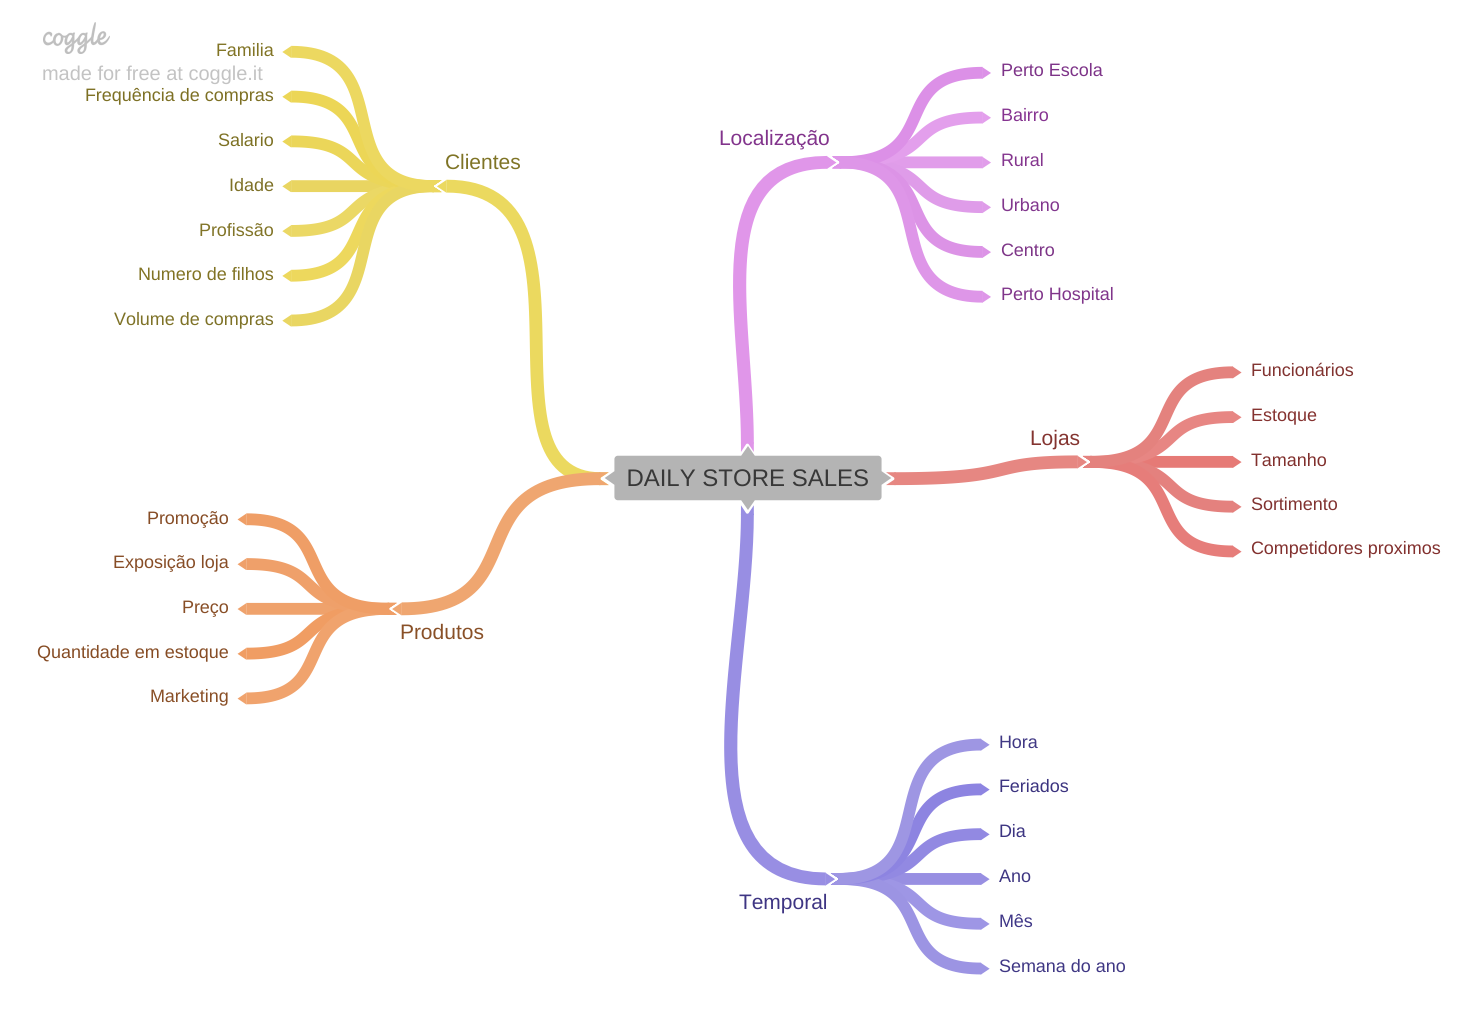

In [29]:
Image('img/mind_map_rossman.png')

## 2.1 Hypotheses criation

### 2.1.1 Store Hypotheses

**1.** Lojas com maior quadro de funcionarios deveriam vender mais

**2.** Lojas com maior estoque deveriam vender mais

**3.** Lojas de maior porte deveriam vender mais

**4.** Lojas com maior sortimento deveriam vender mais

**5.** Lojas com competidores mais proximos deveriam vender menos

**6.** Lojas com competidores a mais tempo deveriam vender mais

### 2.1.2 Product Hypotheses

**1.** Lojas que investem mais em marketing deveriam vender mais

**2.** Lojas que expões mais o produto na vitrine deveriam vender mais

**3.** Lojas que tem preços menores nos produtos deveriam vender mais

**4.** Lojas com promoções mais agressivas deveriam vender mais

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais

**6.** Lojas com mais dias de promoção deveriam vender mais

**7.** Lojas com mais promoções consecutivas deveriam vender mais

### 2.1.3 Time Hypotheses

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos

**3.** Lojas deveriam vender mais no segundo semestre do ano

**4.** Lojas vender mais depois do dia 10 de cada mês

**5.** Lojas deveriam vender menos em finais de semana

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.2 Final Hypotheses List

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais proximos deveriam vender menos

**3.** Lojas com competidores a mais tempo deveriam vender mais

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas vender mais depois do dia 10 de cada mês

**11.** Lojas deveriam vender menos em finais de semana

**12.** Lojas deveriam vender menos durante os feriados escolares


## 2.3 Feature Engineering 

In [30]:
# year

df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year_week
df2['week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] =  ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment 
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# 3.0 Variables Filtering 

In [31]:
df3 = df2.copy()

In [32]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.000,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.000,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.000,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.000,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.000,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Rows Filtering 

In [33]:
df3 = df3.loc[(df3['open'] != 0)  & (df3['sales'] > 0)]

## 3.2 Columns Selection

In [34]:
#'customers' - não está disponivel na hora da predição

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 EDA

In [35]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable 

<AxesSubplot:xlabel='sales', ylabel='Density'>

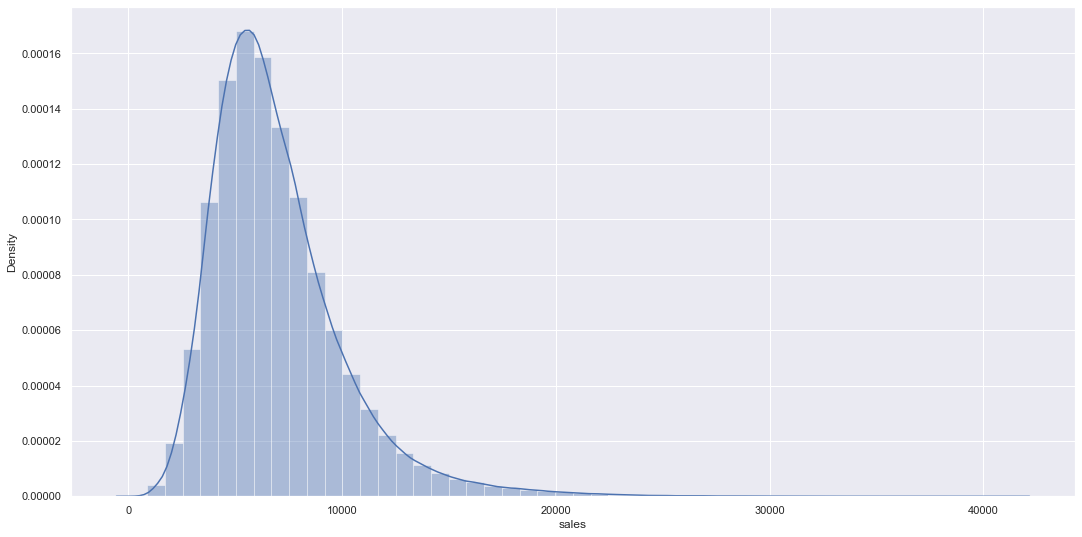

In [36]:
sns.distplot(df4['sales'])

### 4.1.2 Numerical Variables

In [37]:
num_attributes = df1.select_dtypes(include=['int64','float64','int32','float32'])

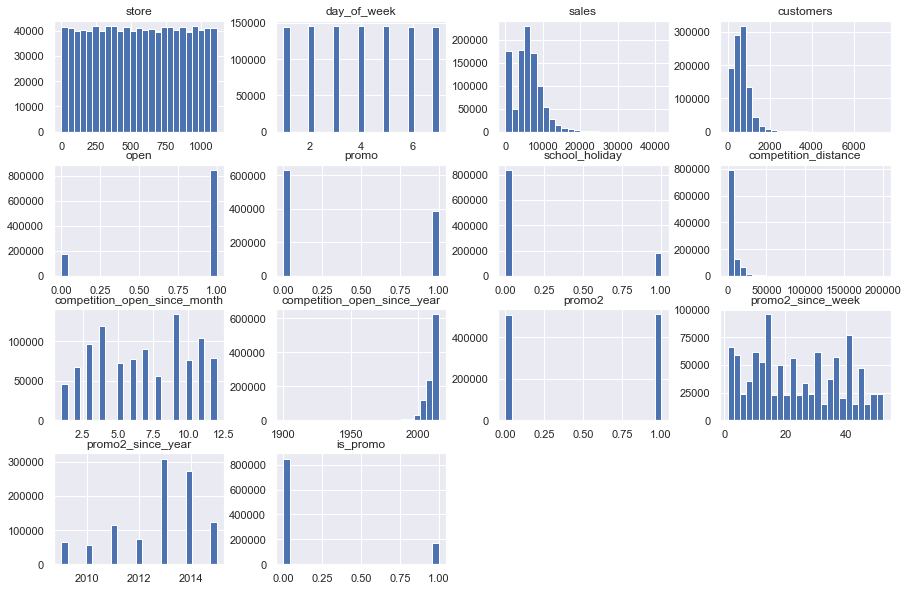

In [38]:
num_attributes.hist(figsize=(15,10), bins=25);

### 4.1.3 Categorical Variables

In [39]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

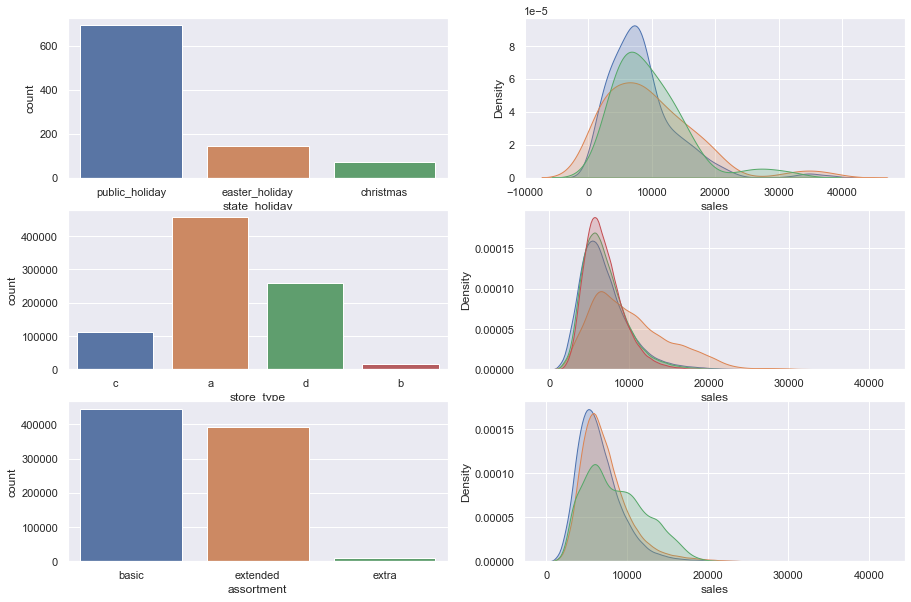

In [40]:
plt.figure(figsize=(15,10))

# state holiday

plt.subplot(3,2,1)
a= df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store type

plt.subplot(3,2,3)

sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment

plt.subplot(3,2,5)

sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)


## 4.2 Bivariate Analysis

### **H1.** Lojas com maior sortimento deveriam vender mais
**Falsa** Lojas com maior sortimento vendem menos

<AxesSubplot:xlabel='week'>

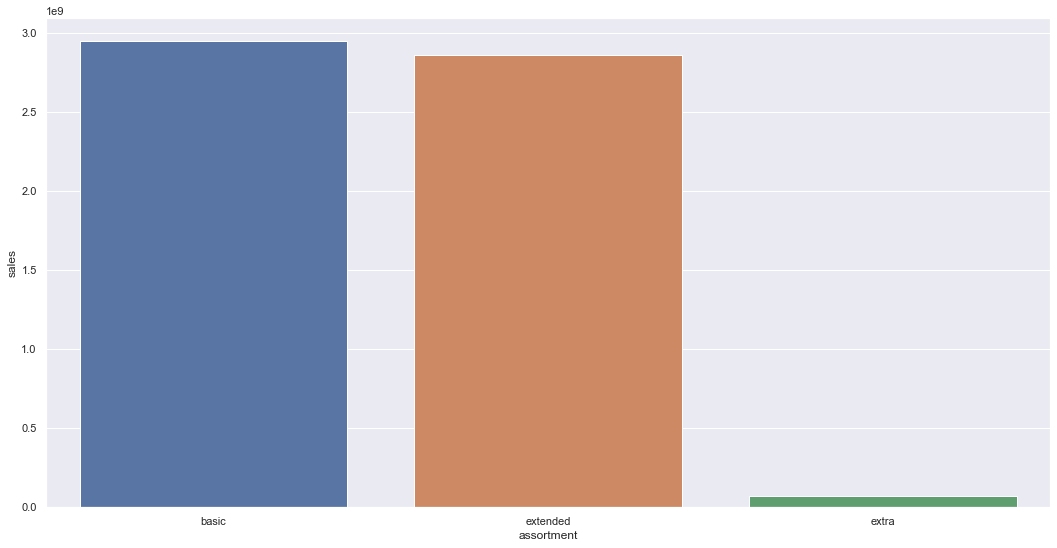

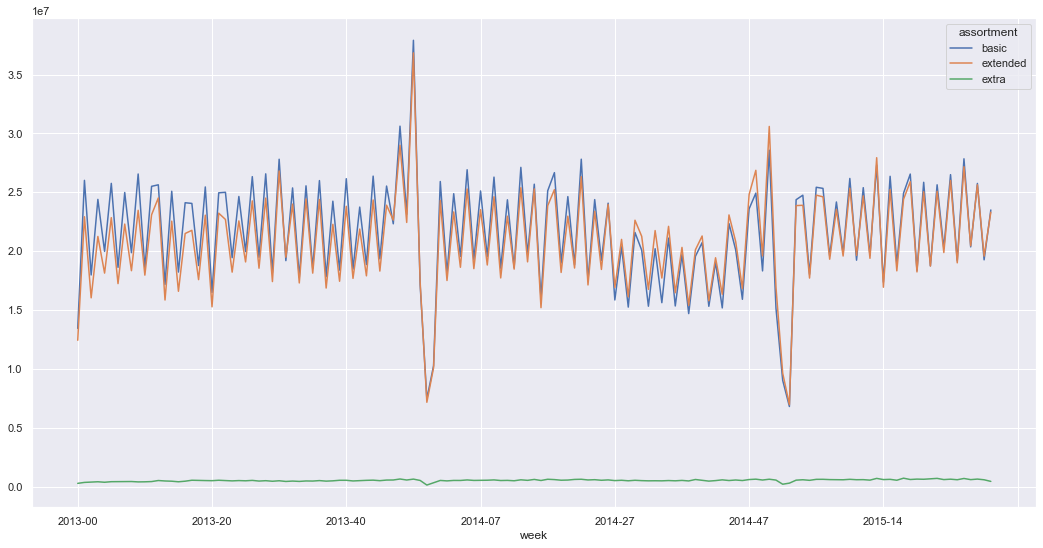

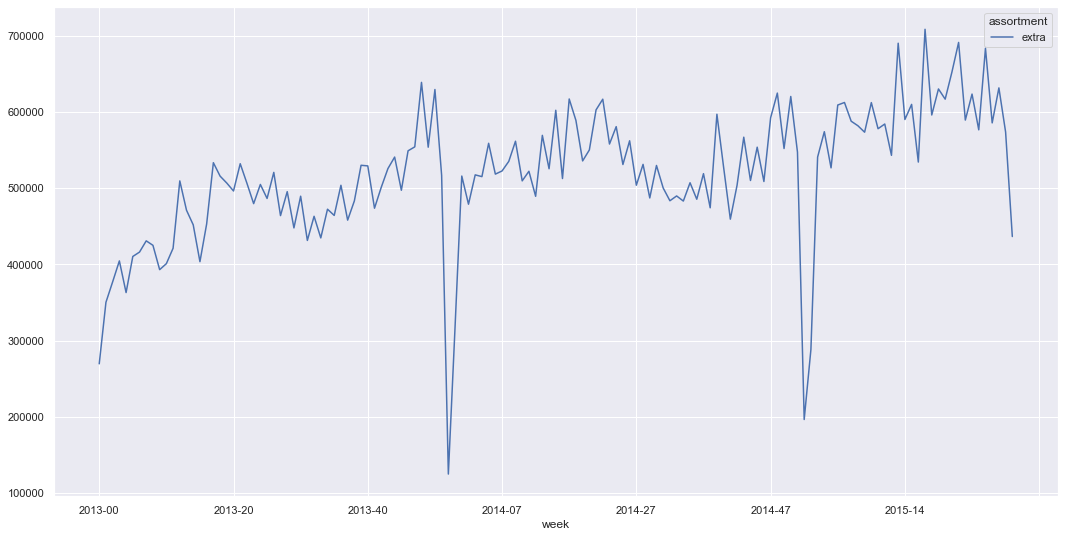

In [41]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales',data=aux1);


aux2 = df4[['week','assortment','sales']].groupby(['week','assortment']).sum().reset_index()
aux2.pivot(index='week',columns='assortment',values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='week',columns='assortment',values='sales').plot()

### **H2.** Lojas com competidores mais proximos deveriam vender menos
**Falsa** Lojas com competidores mais proximos vendem mais

<AxesSubplot:>

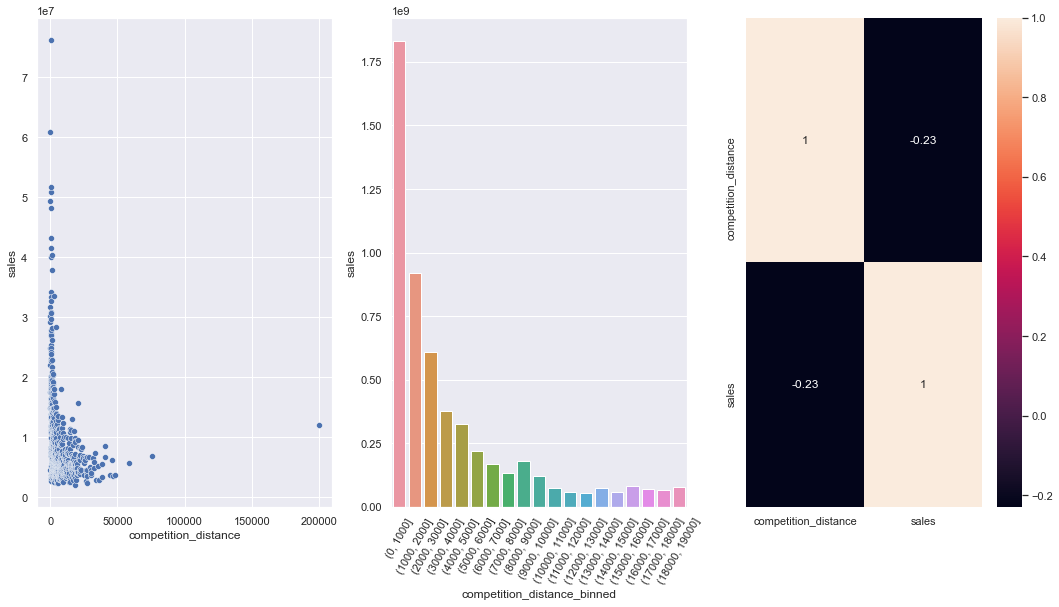

In [42]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0,20000,1000))

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales', data=aux1)

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1,3,2)
sns.barplot(x='competition_distance_binned', y='sales',data=aux2)
plt.xticks(rotation=60)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H3.** Lojas com competidores a mais tempo deveriam vender mais
**Falsa** Lojas com competidores a mais tempo vendem menos

<AxesSubplot:>

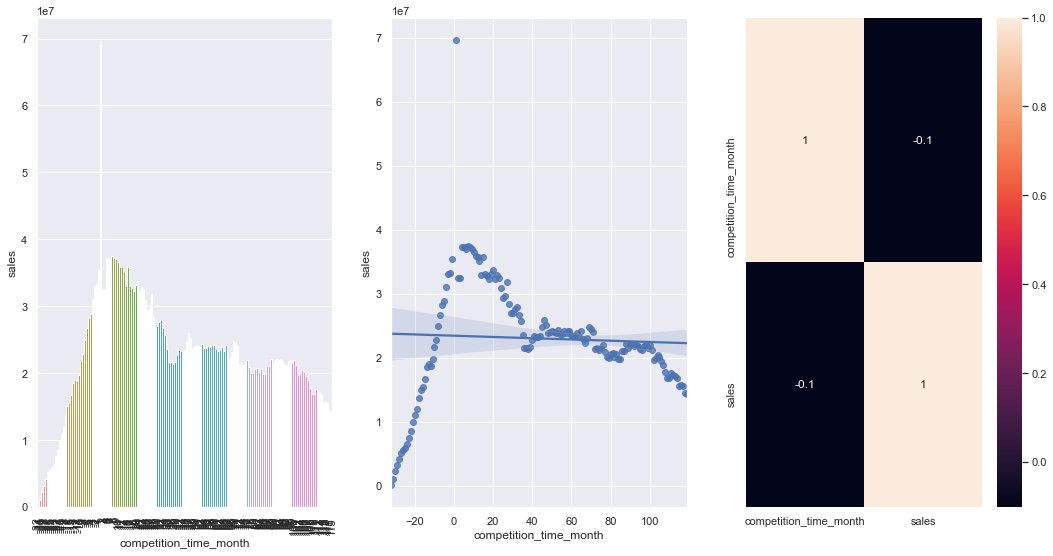

In [43]:
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()

aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

plt.subplot(1,3,1)
sns.barplot(x='competition_time_month',y='sales',data=aux2)
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales',data=aux2)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais
**Falsa** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo periodo de promoção

<AxesSubplot:>

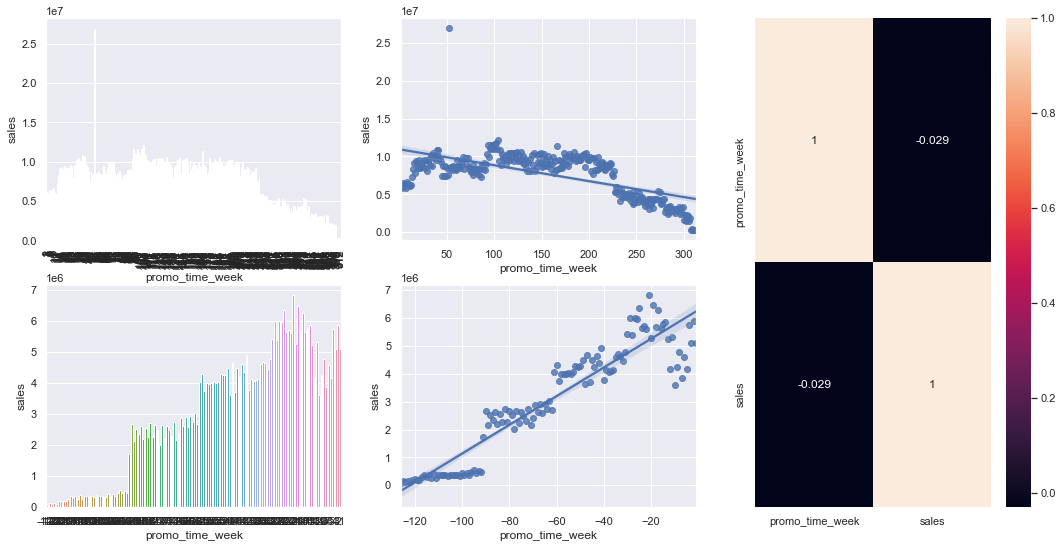

In [44]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo estendido
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### <s> **H5.** Lojas com mais dias de promoção deveriam vender mais <s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais
**Falsa** Lojas com mais promoções consecutivas vendem menos

In [45]:
df4[['promo', 'promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


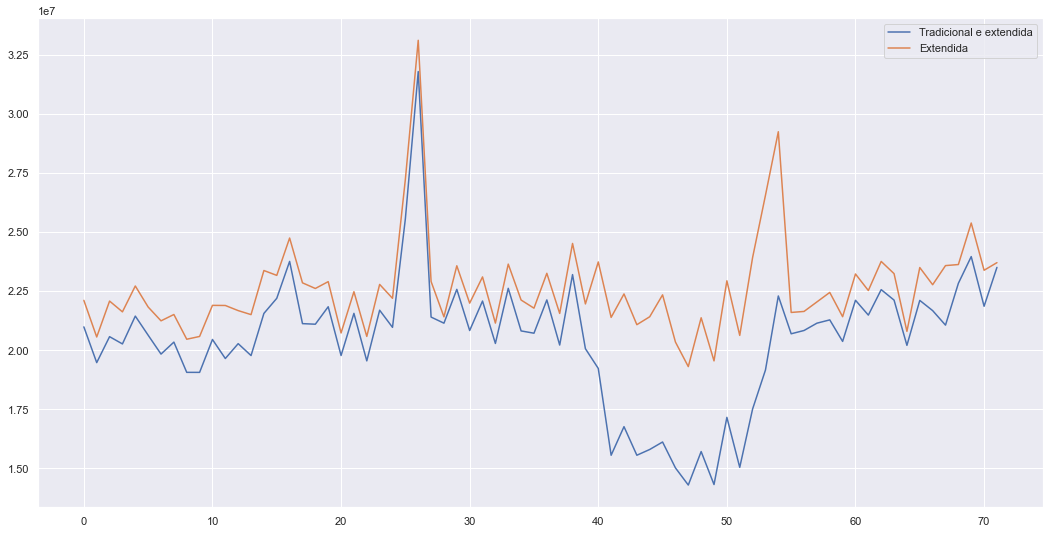

In [46]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['week','sales']].groupby('week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['week','sales']].groupby('week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e extendida', 'Extendida'])

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais
**Falsa** Lojas abertas durante o Natal vendem menos

<AxesSubplot:xlabel='year', ylabel='sales'>

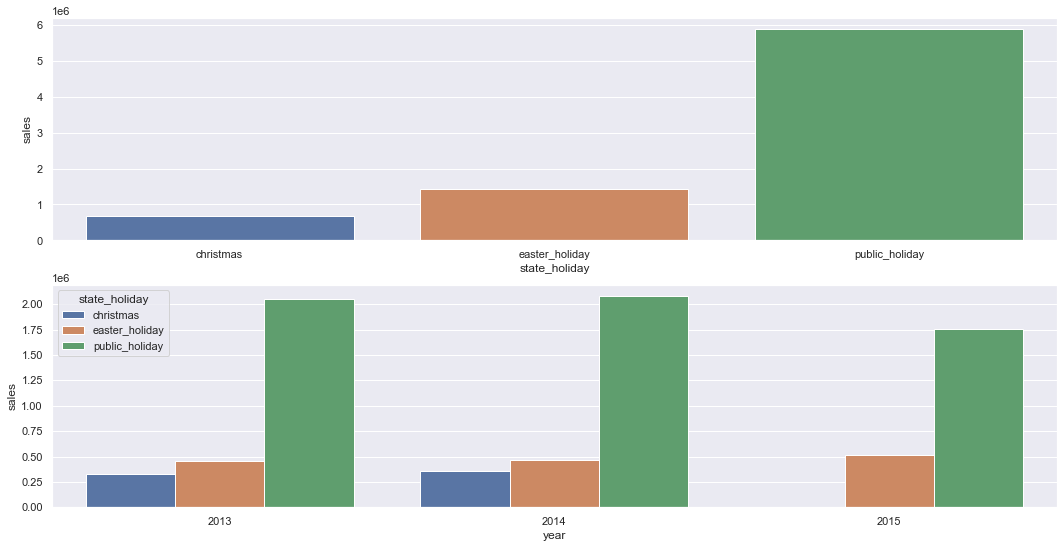

In [47]:
aux= df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='state_holiday',y='sales',data=aux1)

aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='year',y='sales',data=aux2, hue='state_holiday')

### **H8.** Lojas deveriam vender mais ao longo dos anos
**Falsa** As lojas vendem menos ao longo dos anos

<AxesSubplot:>

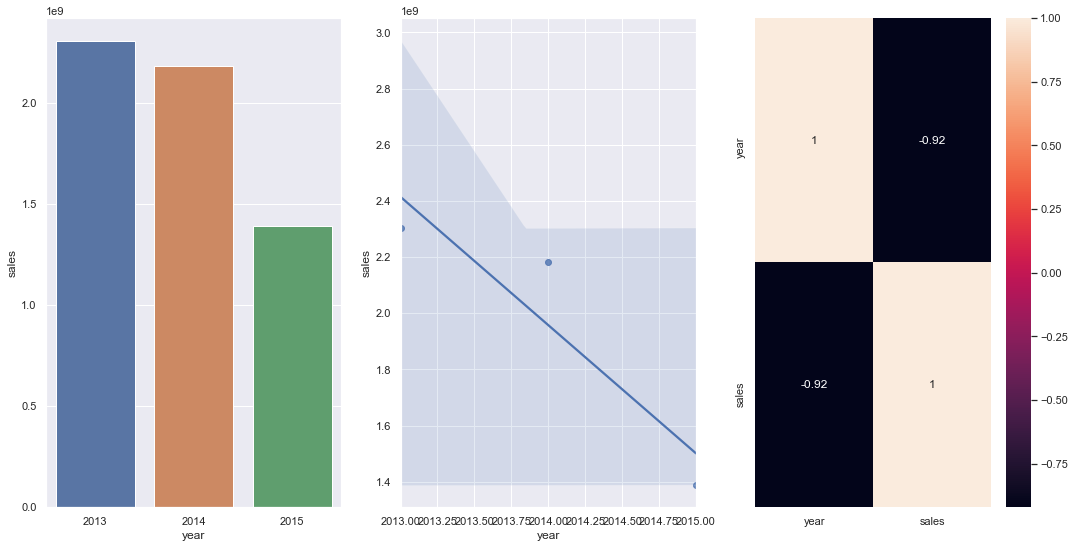

In [48]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H9.** Lojas deveriam vender mais no segundo semestre do ano
**Falsa** Lojas vendem menos no segundo semestre

<AxesSubplot:>

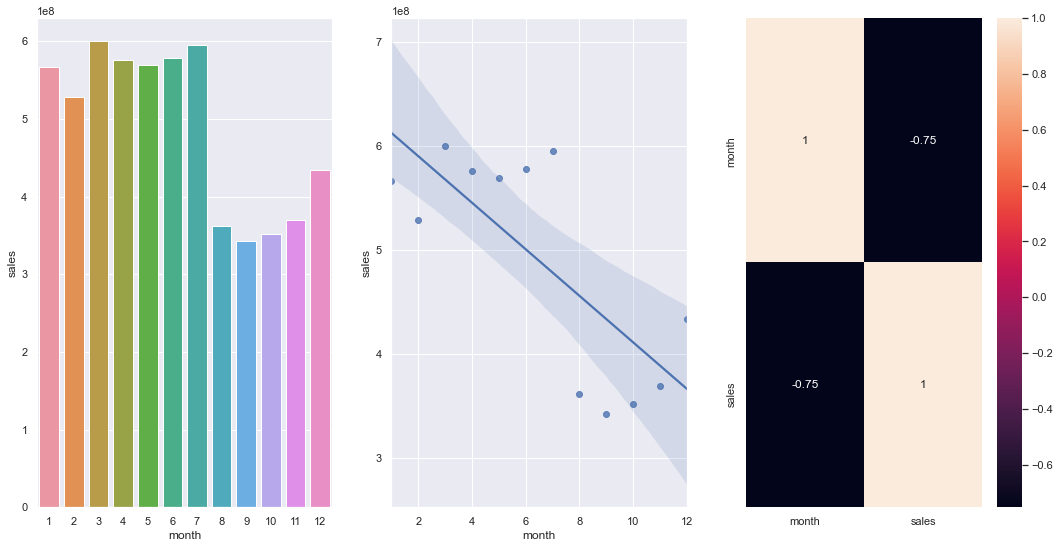

In [49]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data= aux1)

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês
**Verdadeira** Lojas vendem mais depois do dia 10 de cada mes

<AxesSubplot:xlabel='before_after', ylabel='sales'>

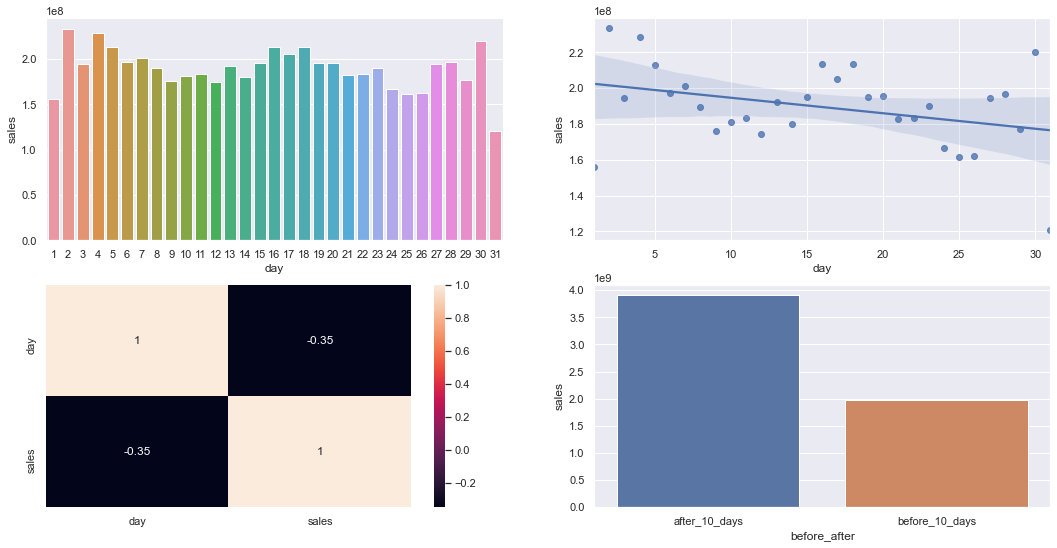

In [50]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data= aux2)

### **H11.** Lojas deveriam vender menos em finais de semana
**Verdadeira** Lojas vendem menos em finais de semana

<AxesSubplot:>

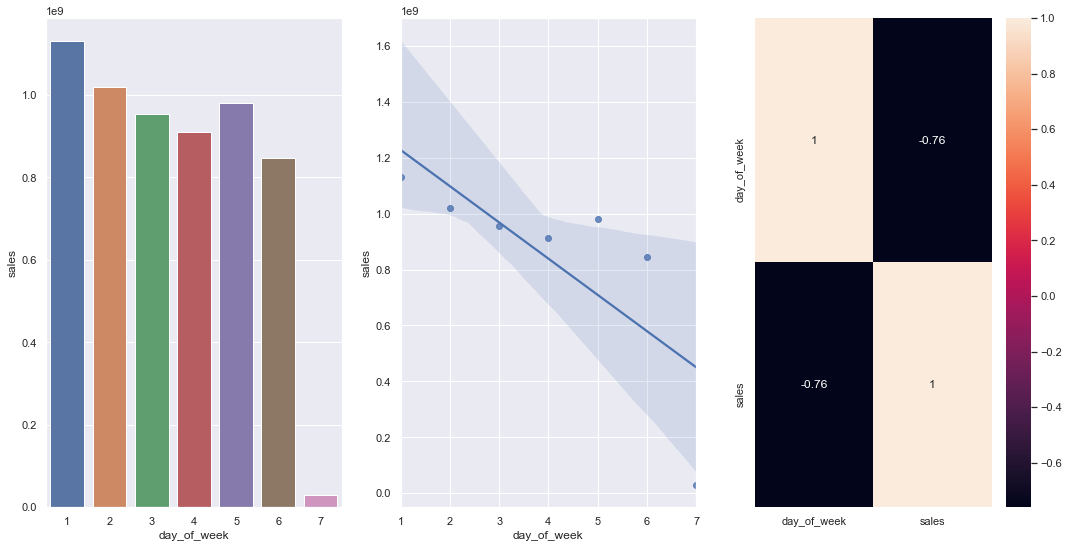

In [51]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **H12.** Lojas deveriam vender menos durante os feriados escolares
**Verdadeira** Lojas vendem menos durante os feriados escolares, exceto os meses de julho e agosto

<AxesSubplot:xlabel='month', ylabel='sales'>

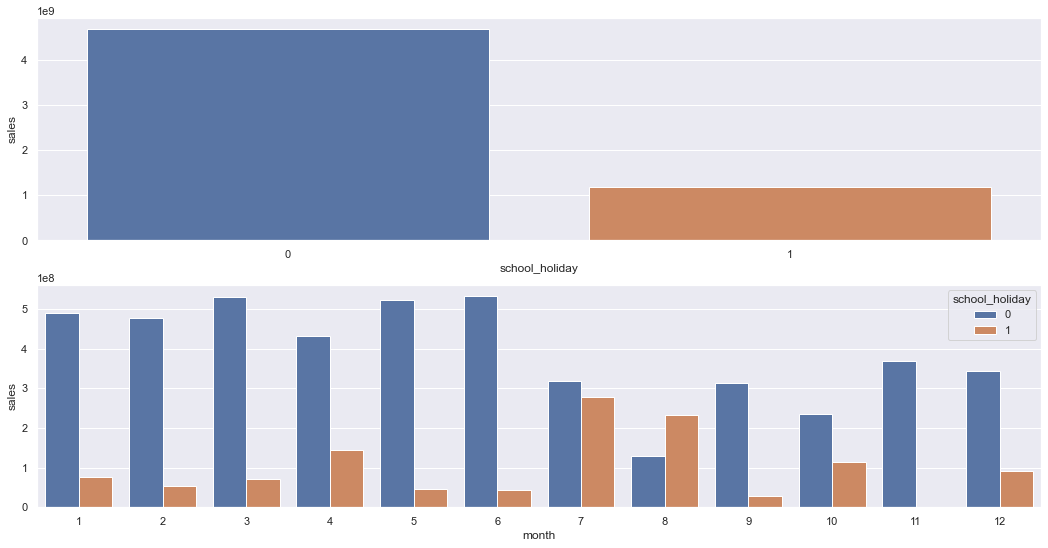

In [52]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1)


plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)

### 4.2.1 Resumo das Hipoteses

In [53]:
from tabulate import tabulate

tab= [['Hipoteses', 'Conclusão', 'Relevancia'],
     ['H1', 'Falsa', 'Baixa'],
     ['H2', 'Falsa', 'Media'],
     ['H3', 'Falsa', 'Media'],
     ['H4', 'Falsa', 'Baixa'],
     ['H5', '--', '---'],
     ['H6', 'Falsa', 'Baixa'],
     ['H7', 'Falsa', 'Media'],
     ['H8', 'Falsa', 'Alta'],
     ['H9', 'Falsa', 'Alta'],
     ['H10', 'Verdadeira', 'Alta'],
     ['H11', 'Verdadeira', 'Alta'],
     ['H12', 'Verdadeira', 'Baixa'],
     ]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusão    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           --           ---
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Multivariate Analysis

###  4.3.1 Numerical Attributes

<AxesSubplot:>

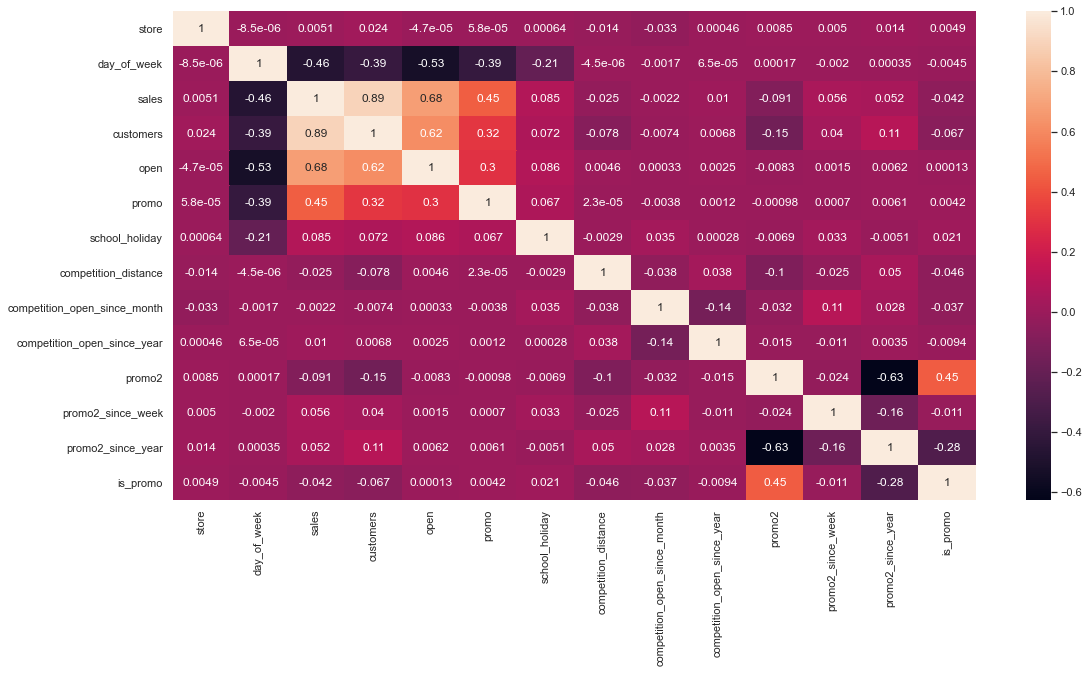

In [54]:
correlation = num_attributes.corr(method='pearson')

sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical Attributes

In [55]:
from scipy import stats

In [56]:
# only categorical data
a = df4.select_dtypes(include='object')
a.head()

,state_holiday,store_type,assortment,week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [57]:
# calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# final dataset
d= pd.DataFrame({'state_holiday': [a1,a2,a3], 
              'store_type': [a4,a5,a6], 
              'assortment': [a7,a8,a9]})

d.set_index(d.columns)

,state_holiday,store_type,assortment
state_holiday,1.000,0.071,0.068
store_type,0.071,1.000,0.538
assortment,0.068,0.538,1.000


<AxesSubplot:>

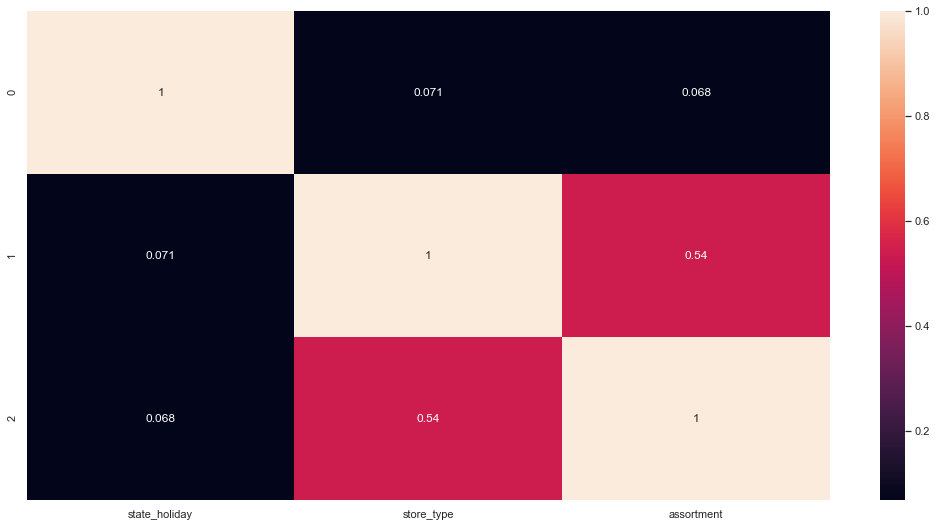

In [58]:
sns.heatmap(d, annot=True)

# 5.0 Data Preparation

In [66]:
df5 = df4.copy()

## 5.1 Normalization

In [60]:
# Devido a analise feita nos graficos da analise univariada, não se percebeu nennuma distribuiçao normal então optou-se 
# por não sei feita a normalização

## 5.2 Rescaling

In [67]:
a = df5.select_dtypes(include=['int64', 'float64', 'int32', 'float32'])

In [68]:
rs = RobustScaler()    # -- usado em variaveis com outliars
mms = MinMaxScaler()   # -- usado em variaveis sem outliars

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameters/competition_distance_scaler.pkl','wb'))

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameters/competition_time_month_scaler.pkl','wb'))

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('parameters/promo_time_week_scaler.pkl','wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameters/year_scaler.pkl','wb'))

## 5.3 Transformation

### 5.3.1 Enconding

In [65]:
# state holiday -- One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type -- Label Encoding
le  = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameters/store_type_scaler.pkl','wb'))

#  assortment -- Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [69]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation

In [70]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))

# 6.0 Feature Selection

In [67]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [68]:
cols_drop = ['week_of_year','day','month','week','promo_since','competition_since','week_of_year']
df6 = df6.drop(cols_drop, axis=1)

In [69]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [70]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training min date: {}'.format(X_train['date'].min()))
print('Training max date: {}'.format(X_train['date'].max()))

print('\nTest min date: {}'.format(X_test['date'].min()))
print('Test max date: {}'.format(X_test['date'].max()))

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00

Test min date: 2015-06-19 00:00:00
Test max date: 2015-07-31 00:00:00


## 6.2 Boruta as feature selector 

In [71]:
# training and test dataset for boruta
#X_train_n = X_train.drop(['date','sales'], axis=1).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

# define boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n,y_train_n)

### 6.2.1 Best features from Boruta

In [72]:
#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop(['date','sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3 Manual Feature Selection

In [73]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )
#cols_selected_boruta.extend(feat_to_add)

# 7.0 Machine Learning Modelling

In [74]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series data preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [75]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# predictions
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result =  ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800,0.455,1835.136


## 7.2 Linear Regression Model

In [76]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediciton
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.090,0.293,2671.049


### 7.2.1 Linear Regression Model - Cross Validation

In [77]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 = / - 295.63,0.3 = / - 0.02,2952.52 = / - 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [78]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediciton
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.705,0.289,2744.452


### 7.3.1 Linear Regression Regularized Model (Lasso) - Cross Validation

In [79]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 = / - 341.5,0.29 = / - 0.01,3057.75 = / - 504.26


## 7.4 Random Forest Regressor

In [80]:
rf = RandomForestRegressor(n_estimators=100, n_jobs= -1, random_state=42).fit(x_train, y_train)

# prediciton
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error(' Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.599,0.100,1011.119


### 7.4.1 Random Forest Regressor - Cross Validation

In [81]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 = / - 217.1,0.12 = / - 0.02,1254.3 = / - 316.17


## 7.5 XGBoost Regressor

In [82]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                n_estimators=100,
                                eta=0.01,
                                max_depth=10,
                                subsample=0.7,
                                colsample_bytree=0.9).fit(x_train, y_train)

# prediciton
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error(' XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.424,0.949,7330.693


### 7.5.1 XGBoost Regressor - Cross Validation

In [83]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.2 = / - 588.65,0.95 = / - 0.0,7715.2 = / - 689.51


## 7.6 Compare Model's performance

### 7.6.1 Single Perfomance

In [84]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.599,0.100,1011.119
0,Average Model,1354.800,0.455,1835.136
0,Linear Regression,1867.090,0.293,2671.049
0,Linear Regression - Lasso,1891.705,0.289,2744.452
0,XGBoost Regressor,6683.424,0.949,7330.693


### 7.6.2 Real Perfomance - Cross Validation

In [85]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 = / - 217.1,0.12 = / - 0.02,1254.3 = / - 316.17
0,Linear Regression,2081.73 = / - 295.63,0.3 = / - 0.02,2952.52 = / - 468.37
0,Lasso,2116.38 = / - 341.5,0.29 = / - 0.01,3057.75 = / - 504.26
0,XGBoost Regressor,7049.2 = / - 588.65,0.95 = / - 0.0,7715.2 = / - 689.51


# 8.0 Hyperparameter Fine Tunning

## 8.1 Random Search

In [86]:
param = {'n_estimators': [1500,1700,2500,3000,3500],
        'eta': [0.01,0.03],
        'max_depth': [3,5,9],
        'subsample': [0.1,0.5,0.7],
        'colssample_bytree': [0.3,0.7,0.9],
        'min_child_weight': [3,8,15]}

max_eval = 10

In [87]:
#final_result = pd.DataFrame()

#for i in range (max_eval):
    #choose values for parameters remdomly
#    hp = {k: random.sample(v,1)[0] for k,v in param.items()}
#    print(hp)
    
    #model
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                    n_estimators=hp['n_estimators'],
#                                    eta=hp['eta'],
#                                    max_depth=hp['max_depth'],
#                                    subsample=hp['subsample'],
#                                    colsample_bytree=hp['colssample_bytree'],
#                                    min_child_weight=hp['min_child_weight'])

    # performance
#    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
#    final_result = pd.concat([final_result, result])
    
#final_result

## 8.2 Final Model

In [88]:
param_tuned = {'n_estimators':3000 ,
        'eta':0.03,
        'max_depth':5 ,
        'subsample': 0.7,
        'colssample_bytree':0.7 ,
        'min_child_weight': 3}

In [89]:
#model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
#                                    n_estimators=param_tuned['n_estimators'],
#                                    eta=param_tuned['eta'],
#                                    max_depth=param_tuned['max_depth'],
#                                    subsample=param_tuned['subsample'],
#                                    colsample_bytree=param_tuned['colssample_bytree'],
#                                    min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)
# prediciton
#yhat_xgb_tuned = model_xgb_tuned.predict(x_test)
    
# performance
#xgb_result_tuned = ml_error(' XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
#xgb_result_tuned


In [90]:
mpe = mean_percentage_error(np.expm1(y_test),np.expm1(yhat_xgb_tuned))
mpe

NameError: name 'yhat_xgb_tuned' is not defined

In [ ]:
# saving model
#pickle.dump(model_xgb_tuned, open('Model/store_sales_prediction_model.pkl','wb'))

# 9.0 Tradução e interpretação do erro

In [104]:
def open_trained_model():
    return open('Model/store_sales_prediction_model.pkl', 'rb')

with open_trained_model() as f:
    model_xgb_tuned = pickle.load(f) 

yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

In [106]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [116]:
# sum of predictions
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE AND MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

#Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

#Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

In [118]:
df92.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
355,356,236806.656,236291.322,237321.990,515.334,0.079
1020,1021,308430.094,307079.364,309780.823,1350.730,0.142
599,600,277802.219,277375.754,278228.683,426.465,0.059
141,142,179713.062,179094.342,180331.783,618.721,0.136
491,492,280273.000,279643.568,280902.432,629.432,0.080


In [121]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107615.711,104215.942,111015.480,3399.769,0.602
908,909,218553.062,210585.819,226520.306,7967.243,0.520
169,170,210332.781,208754.922,211910.640,1577.859,0.389
901,902,202310.547,200840.208,203780.886,1470.339,0.366
875,876,196113.047,192049.000,200177.094,4064.047,0.329


<AxesSubplot:xlabel='store', ylabel='MAPE'>

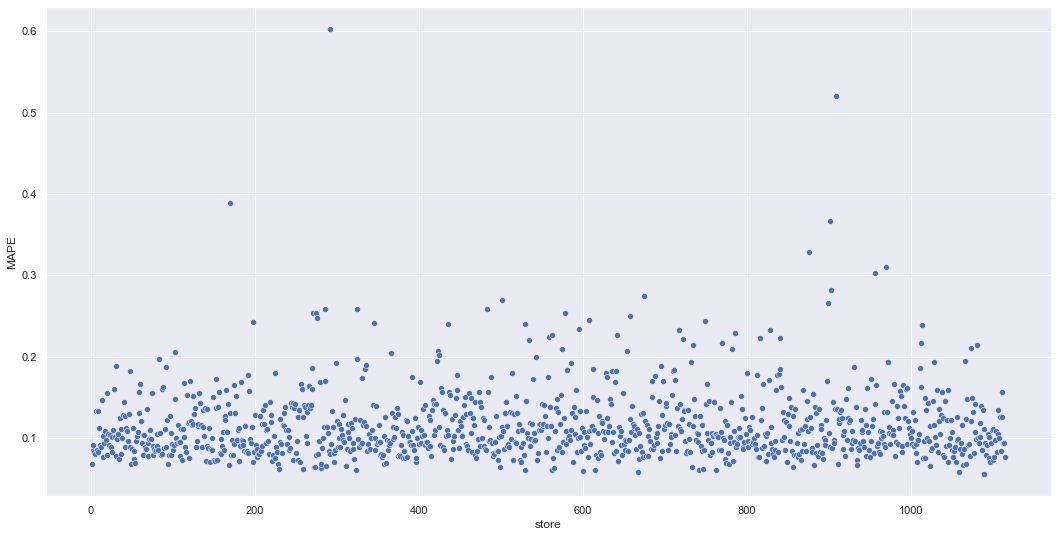

In [120]:
sns.scatterplot(x='store',y='MAPE', data=df92)

## 9.2 Total Performance

In [127]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={0:'Values', 'index':'Scenario'})
df93['Values'] = df93['Values'].map('R$ {:.2f}'. format)
df93

,Scenario,Values
0,predictions,R$ 285982336.00
1,worst_scenario,R$ 285122909.38
2,best_scenario,R$ 286841799.87


## 9.3 Machine Learning Performance

In [128]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

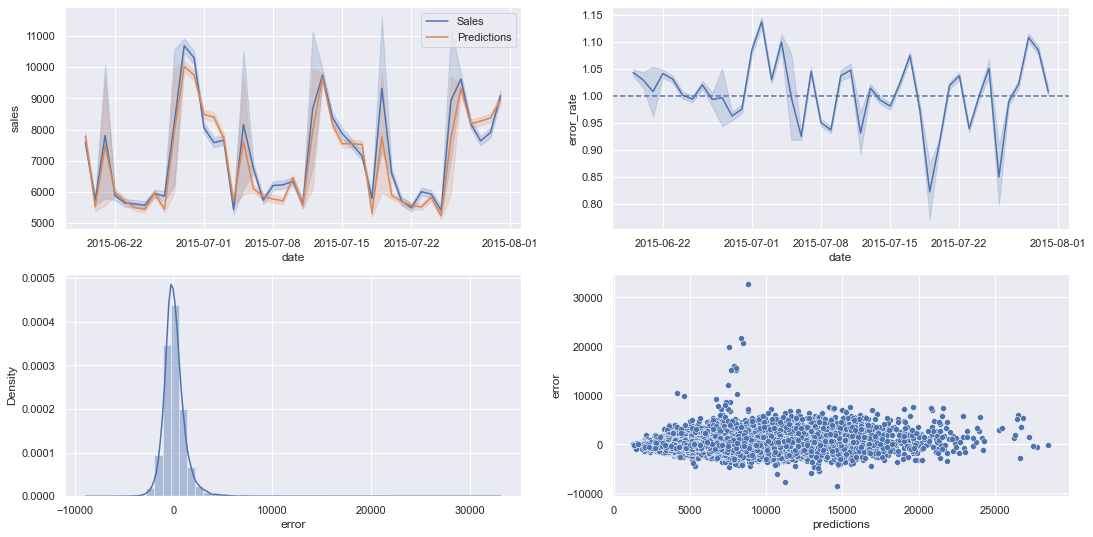

In [130]:
plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales', data=df9, label='Sales')
sns.lineplot(x='date',y='predictions', data=df9, label='Predictions')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error'])

# 10. Deploy Model to Production

## 10.1 Rossmann Class 

In [19]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann (object):
    def __init__(self):
       self.home_path = 'C:/Users/leogr/OneDrive/Documentos/Data Science Projects/Portfolio projects/store-sales-prediction/' 
       self_competition_distance_scaler = pickle.load(open(self.home_path + 'parameters/competition_distance_scaler.pkl','rb'))
       self_competition_time_month_scaler = pickle.load (open(self.home_path + 'parameters/competition_time_month_scaler.pkl','rb'))
       self_promo_time_week_scaler = pickle.load(open(self.home_path + 'parameters/promo_time_week_scaler.pkl','rb')) 
       self_year_scaler = pickle.load(open(self.home_path + 'parameters/year_scaler.pkl','rb'))
       self_store_type_scaler = pickle.load(open(self.home_path + 'parameters/store_type_scaler.pkl','rb'))
    
    def data_cleaning(self, df1):
         
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 
                    'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 
                    'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        df1.columns = cols_new

        # changing date type
        df1['date'] =  pd.to_datetime(df1['date'])

        ## 1.5. Fillout NA
        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)
        
        # competition_open_since_month 
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )

        # competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )

        # promo2_since_week 
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1 )

        # promo2_since_year  
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1 )

        # promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
        
        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        
        #promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

        return df1
   
    def feature_engineering(self, df2):
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year_week
        df2['week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] =  ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment 
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )
        
        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## Filtragem das Linhas
        df2 = df2.loc[(df2['open'] != 0)]
        
        ## Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    def data_preparation(self,df5):
        #Rescaling
        # competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        # competition_time_month
        df5['competition_time_month'] = self_competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        # promo_time_week
        df5['promo_time_week'] = self_promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        
        # year
        df5['year'] = self_year_scaler.fit_transform(df5[['year']].values)
        
        # Encoding
        # state holiday -- One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type -- Label Encoding
        df5['store_type'] = self_store_type_scaler.fit_transform(df5['store_type'])

        #  assortment -- Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)
        
        # Nature Tranformation
        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))
        
        cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month',
                                'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month',
                                'promo_time_week','day_of_week_sin','day_of_week_cos','month_sin', 'month_cos','day_sin','day_cos',
                                'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        pred = model.predict(test_data)
        
        # join pred into original data
        original_data['prediciton'] = np.exmp1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2 API Handler

In [20]:
import pandas as pd
from flask import Flask, request, Response
import requests
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open('C:/Users/leogr/OneDrive/Documentos/Data Science Projects/Portfolio projects/store-sales-prediction/Model/store_sales_prediction_model.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: # multiple exemples
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        # instance rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediciton(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('127.0.0.1')

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [21]:
df10  = pd.read_csv('data/test.csv')

In [22]:
# mwrge test dataset + store

df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

#choose store for prediction
df_test = df_test[df_test['Store'] == 22]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [23]:
# convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [28]:
# API call
#url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'https://rossmann-prediction-model.herokuapp.com/rossmann/predict'
header = {'Content-type' : 'application/json'}
data = data

r = requests.post(url, data = data, headers = header)
print('Status Code {}'.format(r.status_code))

Status Code 500


In [13]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )